## **Using a Convolutional Neural Network to Identify Cube Rotations.**

In this notebook, I will be using images which I have generated using my Shape3D.py and GenerateData.py images, found at https://github.com/javidahmed64592/Y4-Nanoparticles-Project.

I will be using TensorFlow2 and Keras to create a Sequential model which will be trained using the cube images, and then more images will be tested to see if the model can correctly identify their rotations.

The tutorial I followed can be found at https://www.tensorflow.org/tutorials/images/classification.

# Importing the relevant libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import PIL
from scipy.spatial.transform import Rotation as R

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Creating the dataset.

Retrieving images.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

folder_name = "Cubes Unmoving"
direc = os.path.join("/content/drive/MyDrive/Nanoparticles/", folder_name)

Mounted at /content/drive


First, the images to be used for training must be assigned to the training subset. I will be using 80% to train, and 20% to validate. The images are loaded in using PIL and converted to NumPy arrays.

In [3]:
def load_imgs_from_path(folder_path):
  imgs = []
  img_names = []
  labels = []
  
  for rotation in os.listdir(folder_path):
    rotation_path = os.path.join(folder_path, rotation)
    label = json.loads(rotation)
    for image_name in os.listdir(rotation_path):
      labels.append(label)
      img = PIL.Image.open(os.path.join(rotation_path, image_name)).convert('L')

      brightness_enhance = PIL.ImageEnhance.Brightness(img)
      img = brightness_enhance.enhance(np.random.uniform(0.4, 2))

      contrast_enhance = PIL.ImageEnhance.Contrast(img)
      img = contrast_enhance.enhance(np.random.uniform(0.4, 2))

      sharpness_enhance = PIL.ImageEnhance.Sharpness(img)
      img = sharpness_enhance.enhance(np.random.uniform(0.4, 2))

      img_array = np.array(img)
      imgs.append(img_array)
      img_names.append(image_name)

  imgs = np.array(imgs)
  imgs = imgs.reshape(*imgs.shape, 1)

  return np.array(imgs), np.array(img_names), np.array(labels)

In [8]:
training_path = os.path.join(direc, "Train")
validation_path = os.path.join(direc, "Valid")
testing_path = os.path.join(direc, "Test")

train_imgs, train_names, train_labels = load_imgs_from_path(training_path)
valid_imgs, valid_names, valid_labels = load_imgs_from_path(validation_path)
test_imgs, test_names, test_labels = load_imgs_from_path(testing_path)

TensorFlow

In [76]:
img_size = [64, 64]

train_augmentation = keras.Sequential(
  [
    layers.Resizing(*img_size),
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal", input_shape=(*img_size, 1)),
    #layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

test_augmentation = keras.Sequential(
  [
    layers.Resizing(*img_size),
    layers.Rescaling(1./255),
  ]
)

In [77]:
def create_dataset(imgs, labels, aug, batch_size):
  dataset = tf.data.Dataset.from_tensor_slices((imgs, labels))
  dataset = (
    dataset
    .shuffle(batch_size * 10)
    .batch(batch_size)
    .map(lambda x, y: (aug(x), y),
      num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
  )
  return dataset

batch_size = 32

In [78]:
train_dataset = create_dataset(train_imgs, train_labels, train_augmentation, batch_size)
valid_dataset = create_dataset(valid_imgs, valid_labels, train_augmentation, batch_size)
test_dataset = create_dataset(test_imgs, test_labels, test_augmentation, batch_size)

Using data augmentation adds some more variety to the training data, thus resulting in a higher accuracy.

# Creating the model.

In [79]:
def get_model(n_inputs, n_outputs):
  model = Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(*img_size, 1)),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(*img_size, 1)),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Conv2D(64, 3, padding='same', activation='relu', input_shape=(*img_size, 1)),
    layers.MaxPooling2D(pool_size=2, strides=2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(img_size[0], input_dim=n_inputs, activation='relu'),
    layers.Dense(img_size[0] * 2, input_dim=n_inputs, activation='relu'),
    layers.Dense(img_size[0] * 4, input_dim=n_inputs, activation='relu'),
    layers.Dense(img_size[0] * 2, input_dim=n_inputs, activation='relu'),
    layers.Dense(img_size[0], input_dim=n_inputs, activation='relu'),
    layers.Dense(n_outputs, activation="tanh")
  ])

  return model

Creating and compiling the model.

In [140]:
model = get_model(train_imgs.shape[1], train_labels.shape[1])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 32, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_51 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 8, 8, 64)       

# Training the model.

In [141]:
epochs = 50
history = model.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=epochs,
)

Epoch 1/50
90/90 [==============================] - 14s 143ms/step - loss: 0.0386 - accuracy: 0.7476 - val_loss: 0.0468 - val_accuracy: 0.6250
Epoch 2/50
90/90 [==============================] - 13s 140ms/step - loss: 0.0142 - accuracy: 0.5542 - val_loss: 0.0404 - val_accuracy: 0.6250
Epoch 3/50
90/90 [==============================] - 13s 141ms/step - loss: 0.0113 - accuracy: 0.6101 - val_loss: 0.0396 - val_accuracy: 0.6917
Epoch 4/50
90/90 [==============================] - 13s 140ms/step - loss: 0.0094 - accuracy: 0.6125 - val_loss: 0.0393 - val_accuracy: 0.6250
Epoch 5/50
90/90 [==============================] - 13s 140ms/step - loss: 0.0106 - accuracy: 0.5559 - val_loss: 0.0355 - val_accuracy: 0.6250
Epoch 6/50
90/90 [==============================] - 12s 139ms/step - loss: 0.0110 - accuracy: 0.6615 - val_loss: 0.0413 - val_accuracy: 0.6250
Epoch 7/50
90/90 [==============================] - 13s 139ms/step - loss: 0.0130 - accuracy: 0.6115 - val_loss: 0.0415 - val_accuracy: 0.7639

Visualizing the training results.

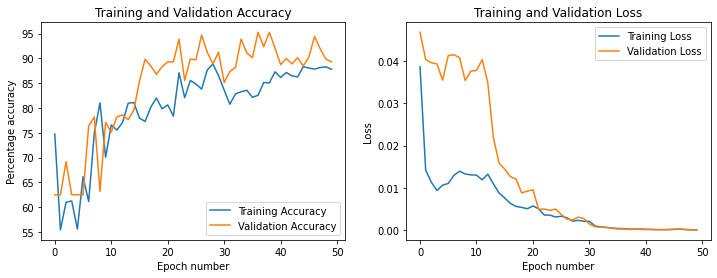

In [142]:
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])

loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc * 100, label='Training Accuracy')
plt.plot(epochs_range, val_acc * 100, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch number")
plt.ylabel("Percentage accuracy")
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.title('Training and Validation Loss')
plt.show()

# Predicting an image.

In [143]:
def predict_image(prediction, img_name):
  name = img_name.split()
  actual_rx = name[2][2:]
  actual_ry = name[3][2:]
  actual_rz = name[4][2:]

  actual_euler = np.array([int(actual_rx), int(actual_ry), int(actual_rz)])

  rotation = np.array(prediction).reshape((2, 3)).T
  v1 = rotation[:, 0]
  v2 = rotation[:, 1]

  e1 = v1 / np.linalg.norm(v1)

  u2 = v2 - ((e1 * v2) * e1)
  e2 = u2 / np.linalg.norm(u2)

  e3 = np.cross(e1, e2) 

  rotation = np.vstack((e1, e2, e3)).T
  rotation_euler = R.from_matrix(rotation).as_euler('xyz', degrees=True)

  # print("Actual: \t%s \t| Predicted: \t%s \t| Difference: \t%s" % (actual_euler, np.round(rotation_euler, 1), np.round(rotation_euler-actual_euler, 1)))

  return (rotation_euler - actual_euler, actual_euler.tolist())

In [144]:
predictions = model.predict(test_dataset)

In [145]:
dr = []
ae = []

for index in range(len(predictions)):
  results = predict_image(predictions[index], test_names[index])
  dr.append(results[0])
  if results[1] not in ae:
    ae.append(results[1])

dr = np.array(dr)

Visualising how accurately the model predicts rotations.

In [146]:
num_rots = len(ae)
imgs_per_rot = test_imgs.shape[0] / num_rots

dr = dr.reshape((num_rots, int(test_imgs.shape[0] / num_rots), 3))

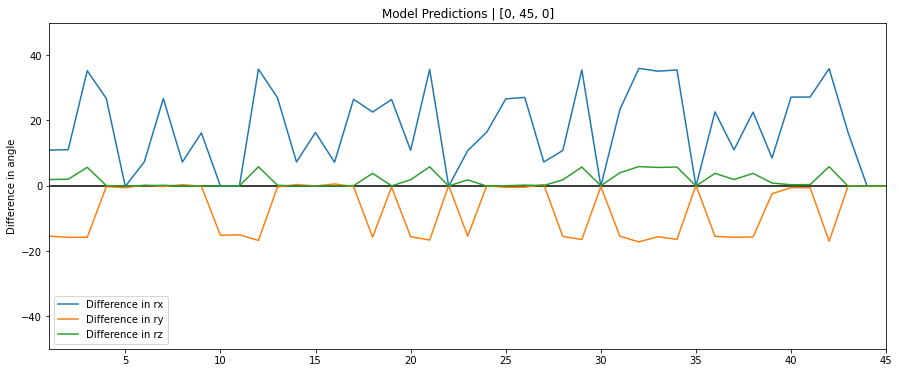

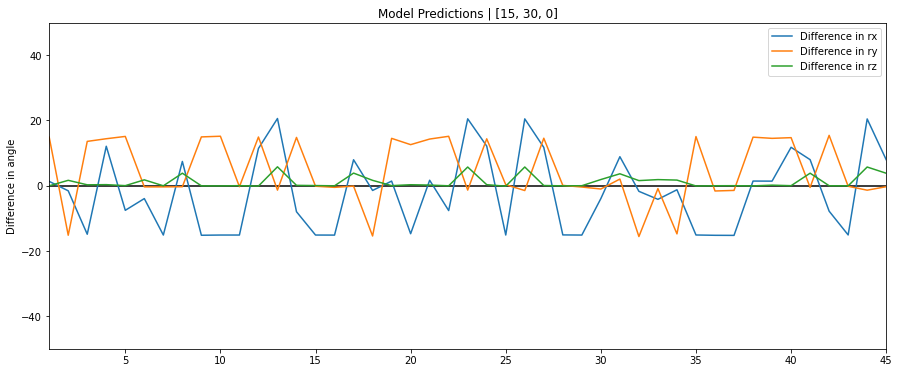

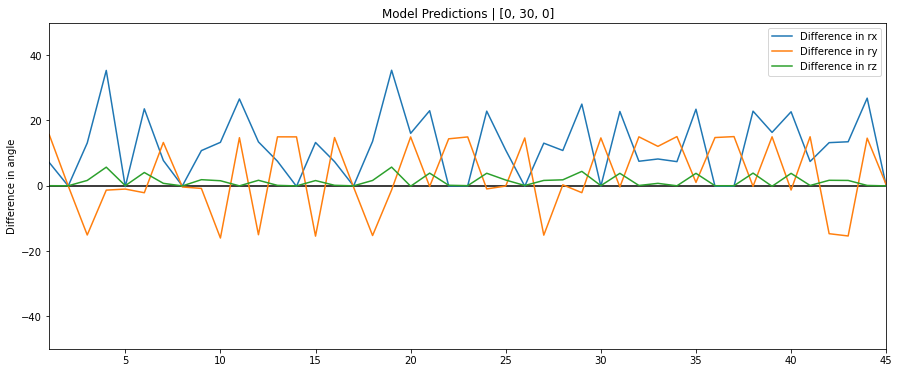

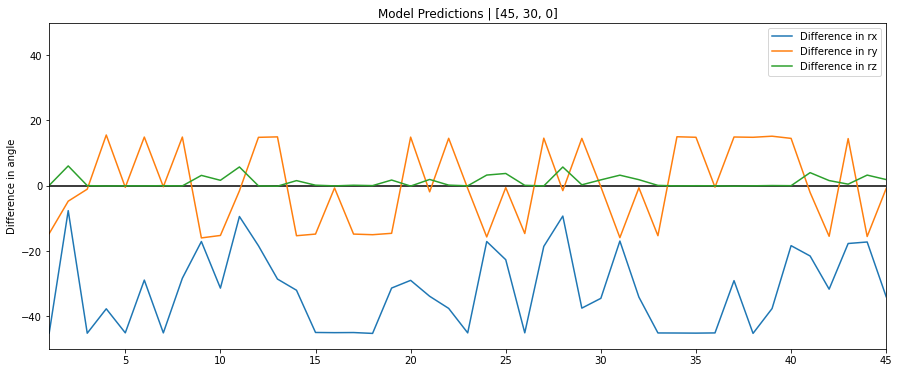

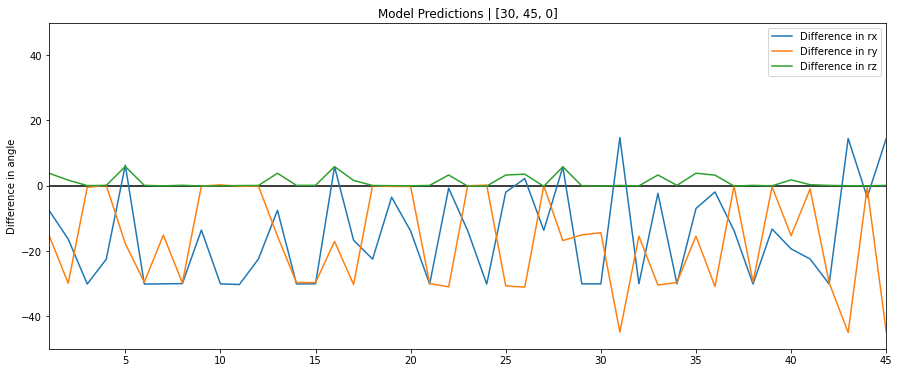

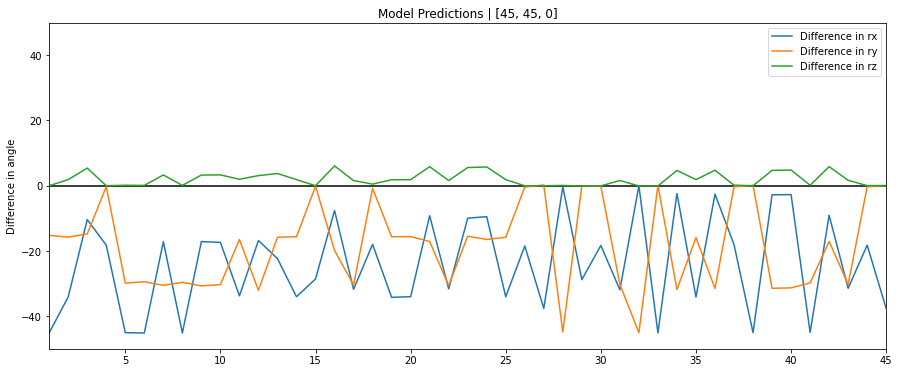

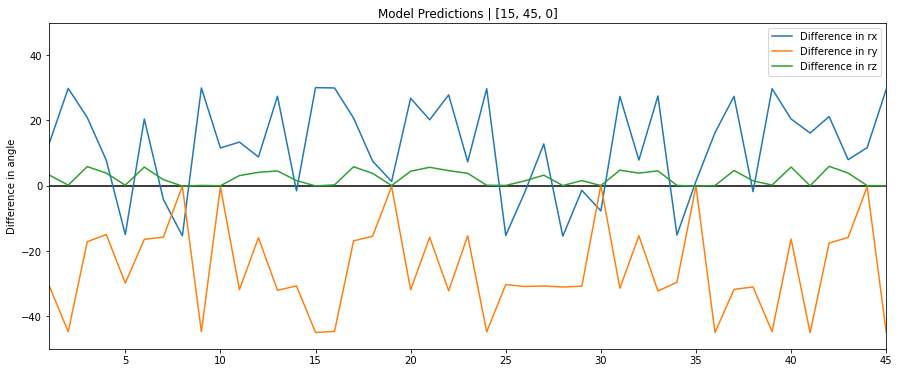

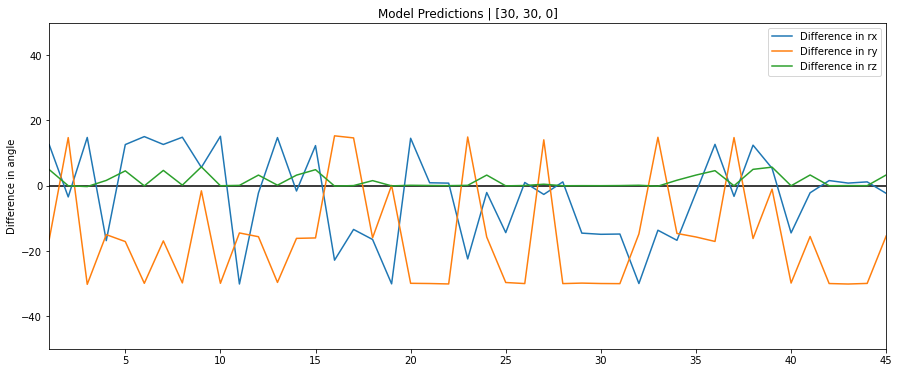

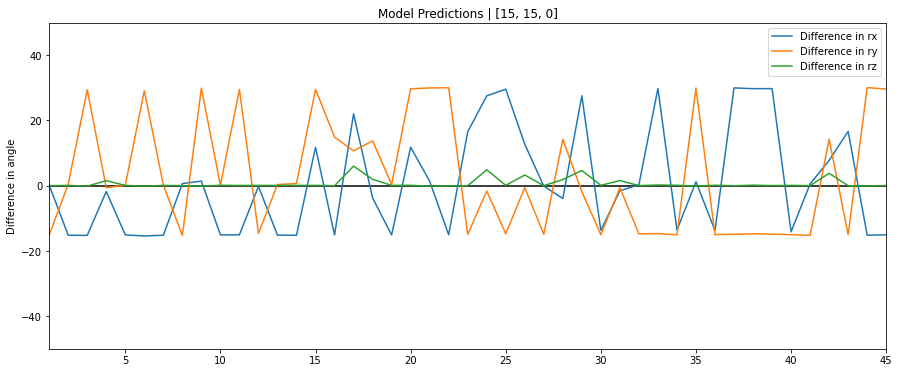

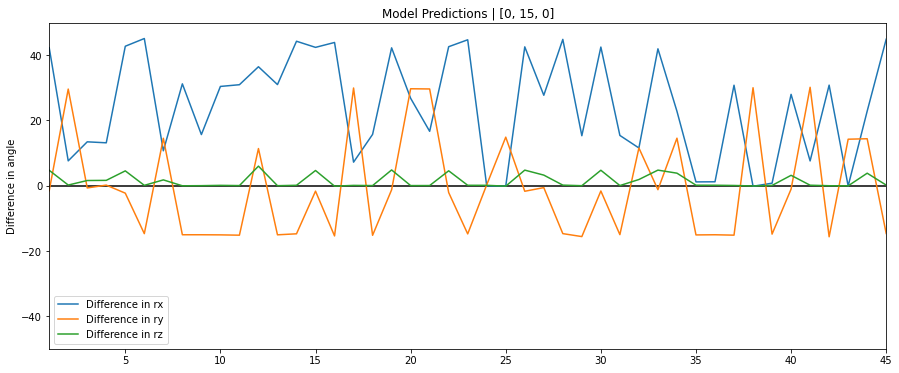

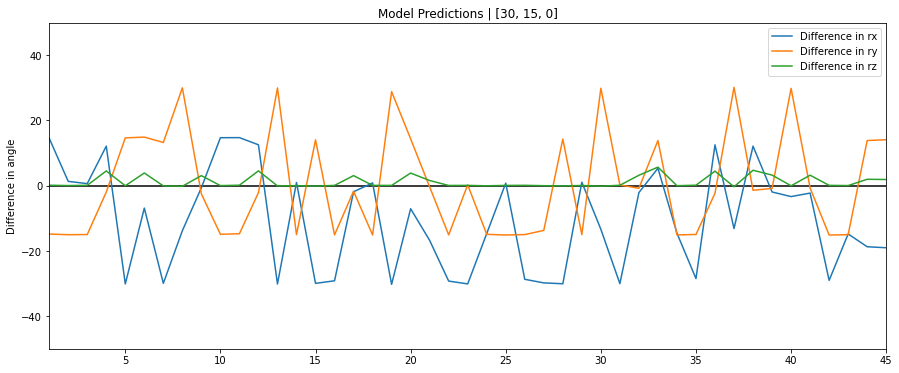

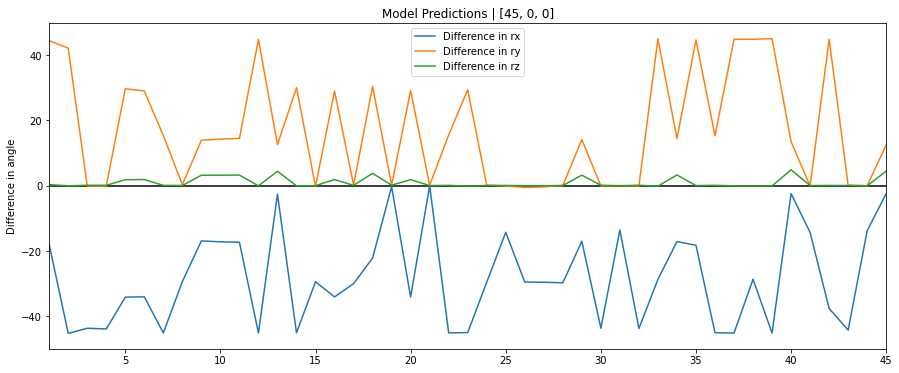

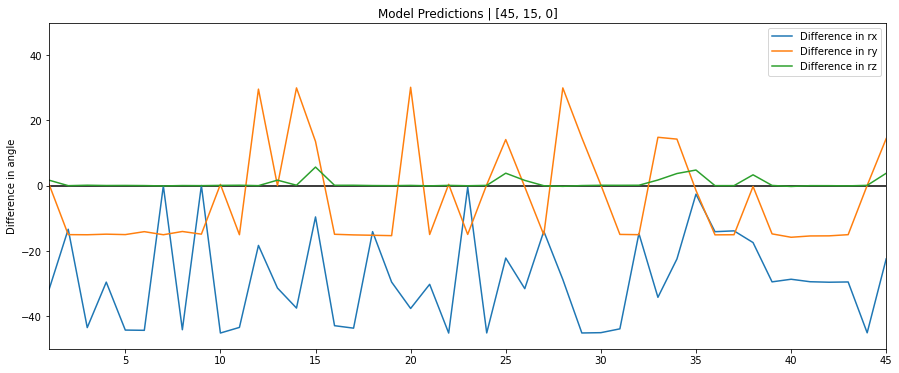

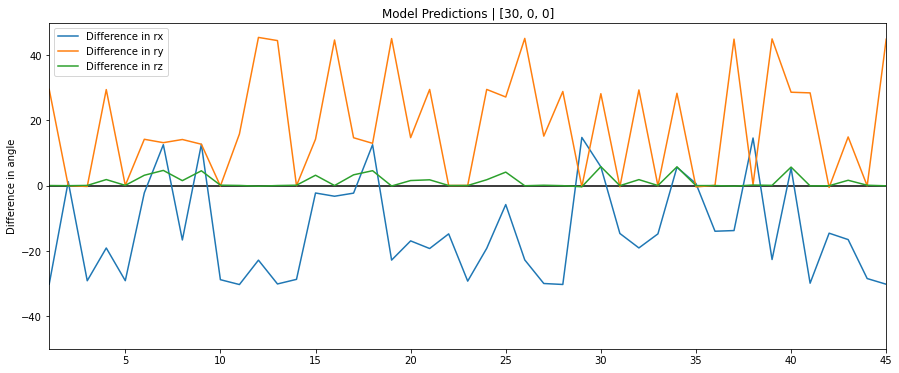

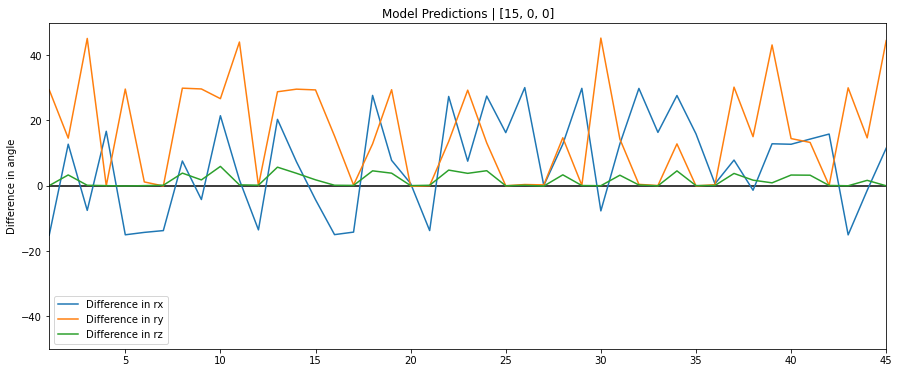

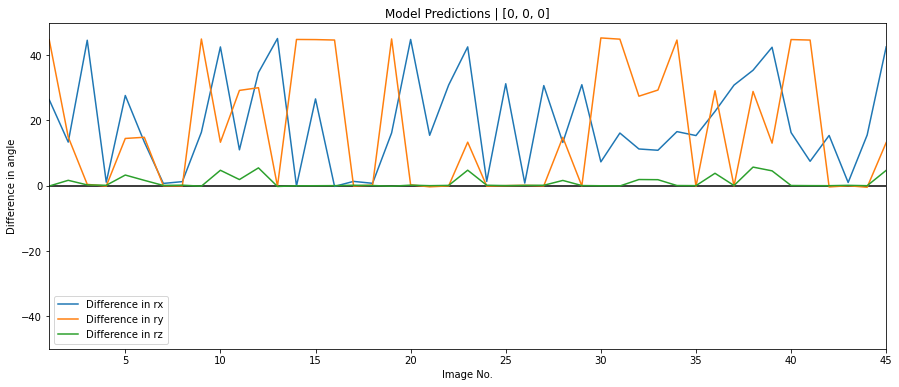

In [147]:
for index in range(dr.shape[0]):
  rot_set = dr[index]
  x = np.arange(rot_set.shape[0]) + 1

  plt.figure(figsize=(15, 6))
  plt.subplot(111)
  plt.plot(x, rot_set[:,0], label="Difference in rx")
  plt.plot(x, rot_set[:,1], label="Difference in ry")
  plt.plot(x, rot_set[:,2], label="Difference in rz")
  plt.hlines(0, x[0], x[-1])
  plt.ylabel("Difference in angle")
  plt.xlim([x[0], x[-1]])
  plt.ylim([-50, 50])
  plt.legend(loc="best")
  plt.title("Model Predictions | %s" % ae[index])

plt.xlabel("Image No.")
plt.show()
  